## 0. Imports

In [1]:
# PyTorch (related) imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import trange
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch device:", device) # Quick check to see if we're using GPU or CPU.

import random
import optuna
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
from pathlib import Path
from IPython.display import clear_output

# Custom imports
import dataset.download_and_preprocess as dl
from dataset.dataloader import KTHDataset
from autoencoder.autoencoder import AutoencoderModel

# for reproducibility
np.random.seed(42)

Torch device: cuda


## 1. Handling the dataset
### A. Download the  KTH dataset and pre-process the dataset into torch tensors
Due to limited computing power we limit our study to the running videos of the KTH dataset only.

In [2]:
dl.download_and_extract(overwrite=False)
dl.extract_and_save_frames()

### B. Define function for uniformaly sampling the data based on frame/video count

In [3]:
def uniform_sampler(num_samples:int = 512) -> tuple[np.ndarray, np.ndarray]:
    """
    Uniformly samples frames from the KTH running dataset, ensuring that the number of samples per video
    is proportional to the video's frame count, for a total of `num_samples` frames.

    Parameters:
        num_samples (int): Total number of frames to sample across all videos (default: 512).

    Returns:
        samples (np.ndarray): Array of sampled frame file paths (Path objects).
        sampled_video_label (np.ndarray): Array of video labels corresponding to each sampled frame.
    """
    folder = Path("dataset") / "KTH_data_running"
    all_files = list(folder.glob("*.pt"))

    total_samples = 0
    unique_files = {}
    # Extract all the video names and count.
    for f in all_files:
        name = f.name.split("_frame_")[0]
        total_samples+=1
        try:
            unique_files[name] += 1
        except KeyError:
            unique_files[name] = 1


    # From all the videos, sample uniformely a count based on the proporiotional occurance in the dataset.
    samples = []
    sampled_video_label = []
    for video, sample_count in unique_files.items():
        # Note: this rounding may cause that we have a few files too much or little but meh.. we have enough
        target_samples = round((sample_count/total_samples) * num_samples) 

        video_frames = list(folder.glob(f"{video}_*.pt"))
        sampled_files = np.random.choice(video_frames, target_samples, replace=False)
        
        samples.extend(sampled_files)
        sampled_video_label.extend([video] * len(sampled_files))
    

    samples = np.array(samples)
    sampled_video_label = np.array(sampled_video_label)

    return samples, sampled_video_label


### C. Define a function that splits the uniformly sampled dataset in to train, validation, and test sets.
Our splitting of data was 70% training, 15% validation & testing.

In [4]:
def dataset_splitter(samples, sampled_video_label, valtest_size:float=0.3) -> tuple[KTHDataset, KTHDataset, KTHDataset]:
    """
    Splits the provided samples and labels into training, validation, and test sets,
    and returns KTHDataset objects for each split with appropriate transforms.

    Parameters:
        samples (np.ndarray): Array of sampled frame file paths (Path objects).
        sampled_video_label (np.ndarray): Array of video labels corresponding to each sampled frame.
        valtest_size (float): Proportion of the dataset to include in the validation and test splits (default: 0.3).

    Returns:
        train_dataset (KTHDataset): Training dataset with augmentation transforms.
        val_dataset (KTHDataset): Validation dataset with basic transforms.
        test_dataset (KTHDataset): Test dataset with basic transforms.
    """
        
    X_train, X_temp, y_train, y_temp = train_test_split(
    samples, sampled_video_label, 
    stratify=sampled_video_label,
    test_size=valtest_size,
    random_state=42
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=42
    )



    # Data augmentation for training
    train_transform = transforms.Compose([
        transforms.Lambda(lambda x: torch.from_numpy(x) if isinstance(x, np.ndarray) else x),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5)
    ])

    val_test_transform = transforms.Compose([
        transforms.Lambda(lambda x: torch.from_numpy(x) if isinstance(x, np.ndarray) else x)
    ])


    train_dataset = KTHDataset(X_train, y_train, transform=train_transform)
    val_dataset = KTHDataset(X_val, y_val, transform=val_test_transform)
    test_dataset = KTHDataset(X_test, y_test, transform=val_test_transform)

    return train_dataset, val_dataset, test_dataset


## 2. Training the model

## A. Plotter functions
These 2 functions are merely for scoring metrics/plotting the performance of the model.

In [5]:
def ssim_accuracy_percent(output, target) -> float:
    """
    Computes SSIM-based accuracy as a percentage.

    Parameters:
        output (torch.Tensor): Reconstructed images (B, C, H, W), values in [0, 1]
        target (torch.Tensor): Ground truth images (B, C, H, W), values in [0, 1]

    Returns:
        float: SSIM-based accuracy in [0, 100]%
    """

    output_np = output.detach().cpu().numpy()
    target_np = target.detach().cpu().numpy()

    ssim_scores = []

    for i in range(output_np.shape[0]):
        out_img = output_np[i, 0]  # Extract 2D image
        tgt_img = target_np[i, 0]
        score = ssim(tgt_img, out_img, data_range=1.0)
        ssim_scores.append(score)

    return 100 * np.mean(ssim_scores)


def plot_model_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs:int, save_path=None, title='fill') -> None:
    """
    Plots training and validation losses and accuracies.

    Parameters:
        train_losses (list): List of training losses.
        val_losses (list): List of validation losses.
        train_accuracies (list): List of training accuracies.
        val_accuracies (list): List of validation accuracies.
        epochs (int): Number of epochs the model trained on (so can be less than 200 due to early-stopping).
        save_path (str): Path to save the plot. If None, the plot will be shown.
        title (str): Title of the plot.
    """
    # Create a figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(8, 5))
    x = np.arange(1, epochs + 1) # x-axis values (1 to epochs)
    ax2 = ax1.twinx()

    # plot accuracies (solid, left y-axis)
    ax2.plot(x, train_losses, label='Train Loss', color='tab:blue', linestyle='--')
    ax2.plot(x, val_losses, label='Val Loss', color='tab:orange', linestyle='--')
    ax2.set_ylabel('Loss')
    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left()
    
    # plot accuracies (solid, right y-axis)
    ax1.plot(x, train_accuracies, label='Train Accuracy', color='tab:blue')
    ax1.plot(x, val_accuracies, label='Val Accuracy', color='tab:orange')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlim(1, epochs+1)

    ax1.set_ylim(30, 100)  # Set y-axis limits for accuracy
    ax1.set_yticks(np.arange(30, 101, 10))  # Set y-ticks for accuracy
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()

    # Legends and title
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
    ax1.set_title(title)

    # Show or save the plot
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        plt.close(fig)

## B. The actual training of the autoencoder

In [6]:
def train_autoencoder(model:AutoencoderModel, train_loader, val_loader, patience:int = 10, learning_rate:float = 1e-3):
    """
    Training loop for the autoencoder model, which is trained using adam optimizer and MSE loss.
    The training stops if the validation loss does not improve for a specified number of epochs (patience).

    Parameters:
        model (autoencoder.AutoencoderModel): The autoencoder model to be trained. (it has all parameters such as learning rate and epochs)
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        patience (int): Number of epochs with no improvement after which training will be stopped.

    Returns:
        tuple: A tuple containing:
            - train_losses (list): List of training losses.
            - val_losses (list): List of validation losses.
            - train_accuracies (list): List of training accuracies.
            - val_accuracies (list): List of validation accuracies.
    """
    best_val_loss = float("inf")
    epochs_no_improve = 0

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    train_accuracies = []
    train_losses = []

    val_accuracies = []
    val_losses = []

    #for epoch in range(model.epochs):
    for epoch in trange(model.epochs, desc="Epochs"):
        model.trained_epochs += 1
        # Training
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        for images, _ in train_loader:
            images = images.unsqueeze(1).to(device)
            outputs = model(images)
            
            loss = loss_fn(outputs, images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            running_accuracy += ssim_accuracy_percent(outputs, images) * images.size(0)


        epoch_accuracy = running_accuracy / len(train_loader.dataset)
        epoch_loss = running_loss / len(train_loader.dataset)
        
        train_accuracies.append(epoch_accuracy)
        train_losses.append(epoch_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.unsqueeze(1).to(device)
                outputs = model(images)
                loss = loss_fn(outputs, images)
                val_loss += loss.item() * images.size(0)
                val_accuracy += ssim_accuracy_percent(outputs, images) * images.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        val_accuracy = val_accuracy / len(val_loader.dataset)
        val_accuracies.append(val_accuracy)


        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            model.save(Path("autoencoder")/ "models", filename="Current_best")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

        clear_output(True)
        print(f"Loss: {val_loss:5f}\tAccuracy: {val_accuracy:4.1f}")
                
    return train_losses, val_losses, train_accuracies, val_accuracies

## 3. Training and optimizing our latent space using optuna
### A. Define our optuna function that tells us the best possible latent space|

In [7]:
def optuna_optimization(trial:optuna.Trial, train_loader:DataLoader, val_loader:DataLoader):
    """
    Objective function for Optuna optimization.

    Parameters:
        trial (optuna.Trial): Optuna trial object.

    Returns:
        float: Validation loss.
    """
    
    # Define the hyperparameters to optimize
    latent_dim = trial.suggest_int(name="Latent space", low=16, high=2048)
    
    # Train the model
    model =  AutoencoderModel(latent_dim=latent_dim, epochs=200).to(device)
    train_losses, val_losses, train_accuracies, val_accuracies = train_autoencoder(model, train_loader, val_loader, patience=5, learning_rate=1e-3)

    # Determine best metrics for this model
    best_loss = min(val_losses)
    best_accuracy = max(val_accuracies)

    # Save the model
    model.save(filename=f"model_trial_{trial.number}_{latent_dim}")
    trial.set_user_attr("epochs_run", model.trained_epochs)
    
    # Save the plot
    save_path = Path("plots") / "autoencoder_training"
    save_path.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist
    save_path = save_path / f"trial_{trial.number}.png"
    plot_model_metrics(train_losses, val_losses, train_accuracies, val_accuracies, model.trained_epochs, save_path=save_path, title=f"Trial {trial.number} - Loss: {best_loss:.4f} - Acc: {best_accuracy:00.1f}")
    
    return best_loss  # Return the minimum validation loss

In [9]:
# Fetch the files and split
samples, labels = uniform_sampler(10240)
train, val, test = dataset_splitter(samples, labels)

# Data loaders
train_loader = DataLoader(train, batch_size=1024)
val_loader = DataLoader(val, batch_size=1024, shuffle=False)


# Optuna study 

# Study parameters
search_space = {"Latent space": [16, 32, 64, 128, 512, 1024, 2048]}
n_trials = 0 # Set this to 0 as we're done; should be set to 7.

print(search_space)

study = optuna.create_study(direction="minimize", 
                            study_name="Autoencoder Optimization", 
                            storage="sqlite:///autoencoder_study.db", 
                            load_if_exists=True, 
                            sampler=optuna.samplers.GridSampler(search_space)
                            )

studydf = study.trials_dataframe()

# Check if study has previously failed
if studydf.empty or studydf[studydf["state"] != "FAIL"].empty:
		n_trials_to_complete = n_trials
else:
    trialdf = studydf[studydf["state"] != "FAIL"]
    n_trials_to_complete = n_trials-trialdf.shape[0]
    print(f"finishing study by running {n_trials_to_complete} trials")


study.optimize(lambda trial: optuna_optimization(trial, train_loader, val_loader), n_trials=n_trials_to_complete, n_jobs=1)

# Display the study results
studydf = pd.read_pickle("autoencoder_study_results.pkl")
studydf

{'Latent space': [16, 32, 64, 128, 512, 1024, 2048]}


[I 2025-06-02 17:01:39,451] A new study created in RDB with name: Autoencoder Optimization


,value,duration,params_Latent space,user_attrs_epochs_run,state
8,0.001124,0 days 01:04:43.384151,128,98.0,COMPLETE
5,0.001241,0 days 02:22:42.573585,512,87.0,COMPLETE
0,0.001459,0 days 02:19:05.296278,64,96.0,COMPLETE
3,0.001547,0 days 02:03:36.286163,1024,81.0,COMPLETE
4,0.001555,0 days 02:13:34.981768,2048,77.0,COMPLETE
2,0.001982,0 days 02:28:58.416677,16,96.0,COMPLETE
1,0.002057,0 days 01:23:11.385861,32,53.0,COMPLETE


## C. Load our models

In [ ]:
model_path = Path("autoencoder") / "models"

model_16 = AutoencoderModel(16, 0).to(device)
model_16.load(model_path/ "model_16.pt")
model_16.eval()

model_32 = AutoencoderModel(32, 0).to(device)
model_32.load(model_path/ "model_32.pt")
model_32.eval()

model_64 = AutoencoderModel(64, 0).to(device)
model_64.load(model_path/ "model_64.pt")
model_64.eval()

model_128 = AutoencoderModel(128, 0).to(device)
model_128.load(model_path/ "model_128.pt")
model_128.eval()

model_512 = AutoencoderModel(512, 0).to(device)
model_512.load(model_path/ "model_512.pt")
model_512.eval()

model_1024 = AutoencoderModel(1024, 0).to(device)
model_1024.load(model_path/ "model_1024.pt")
model_1024.eval()

model_2048 = AutoencoderModel(2048, 0).to(device)
model_2048.load(model_path/ "model_2048.pt")
model_2048.eval()

models = [model_16, model_32, model_64, model_128, model_512, model_1024, model_2048]
model_names = ["16", "32", "64", "128", "512", "1024", "2048"]

## 4. Visual inspection of the networks output

### A. Display randomly sampled original and reconstructed images

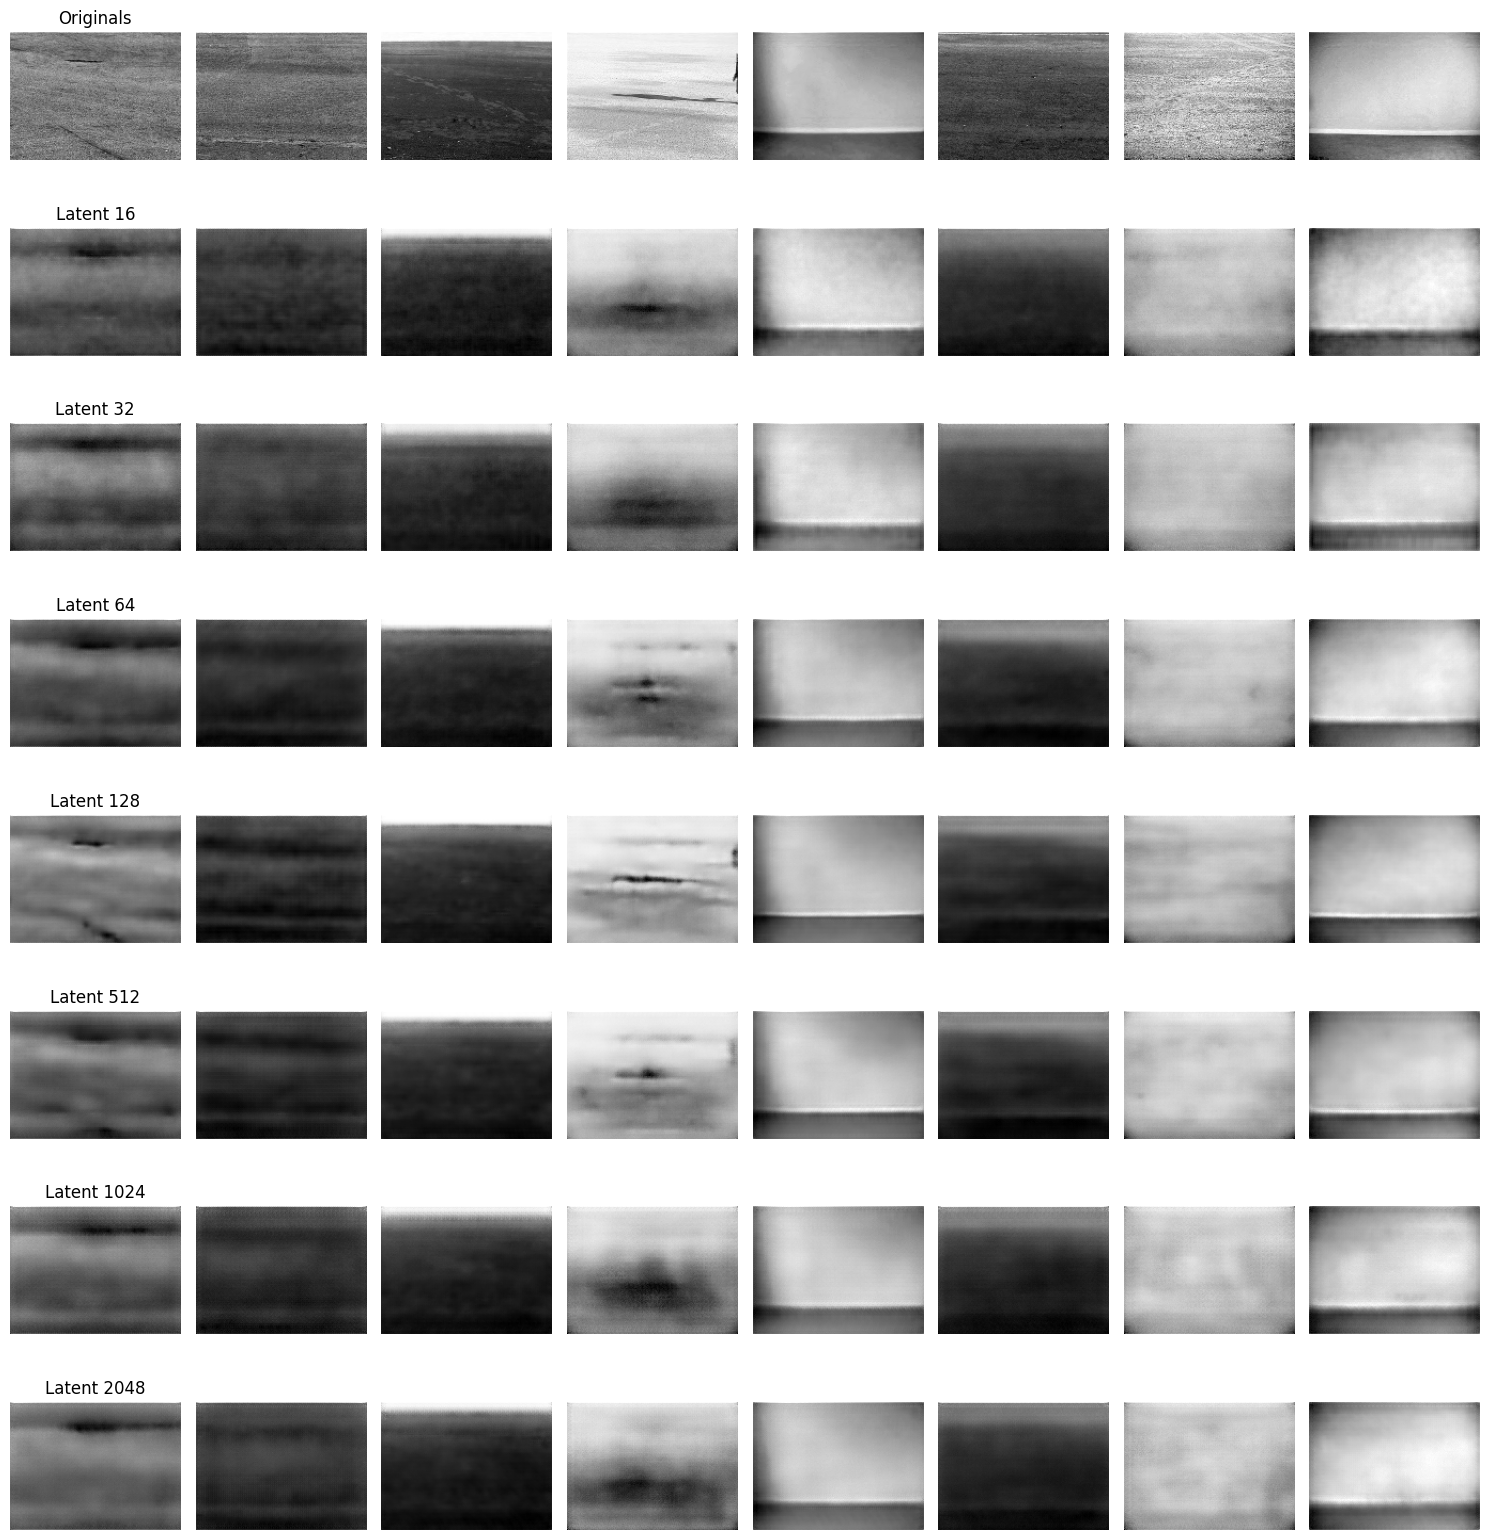

In [ ]:
# Set all models to eval mode
for model in models:
    model.eval()

# Grab 8 random images from the test set
with torch.no_grad():
    indices = random.sample(range(len(test)), 8)
    sample_imgs = torch.stack([test[i][0] for i in indices])
    sample_imgs = sample_imgs.unsqueeze(1).to(device)

    # Get reconstructions from each model
    reconstructions_list = [model(sample_imgs) for model in models]

# Prepare the plot
num_models = len(models)
fig, axs = plt.subplots(num_models + 1, 8, figsize=(15, 2 * (num_models + 1)))

# Plot originals
for i in range(8):
    axs[0, i].imshow(sample_imgs[i, 0].cpu(), cmap='gray')
    axs[0, i].axis('off')
axs[0, 0].set_title("Originals")

# Plot reconstructions from each model
for row, (reconstructions, name) in enumerate(zip(reconstructions_list, model_names), start=1):
    for i in range(8):
        axs[row, i].imshow(reconstructions[i, 0].cpu(), cmap='gray')
        axs[row, i].axis('off')
    axs[row, 0].set_title(f"Latent {name}")

plt.tight_layout()
plt.show()


### Lastly, we encode and save the full dataset for further training PredRNN
We do this with our best two models with latent spaces 128 and 512. (Sorry for some of the hardcoded mess)

In [ ]:
folder = Path("dataset") / "KTH_data_running"

for model, latent_space in zip([model_128, model_512], ['128', '512']):
    # Create a directory for the model
    output_dir = Path("dataset") / "encoded" / f"latent_{latent_space}"
    output_dir.mkdir(parents=True, exist_ok=True)

    # Process each video in the dataset
    for file in folder.glob("*.pt"):

        # Load the file and do a encoding pass through the model
        with torch.no_grad():
            video_frames = torch.load(file).unsqueeze(0).unsqueeze(0).to(device)
            encoded = model.encode(video_frames)
        
        # Save the encoded representation of the frame
        output_path = output_dir / file.name
        torch.save(encoded.cpu(), output_path)